# Investigating OpenAlex data: cited references
#### Eric Schares, Iowa State University; [eschares.github.io](eschares.github.io) 
 
---

<div style='background:#e7edf7'>
    This notebook will query the OpenAlex API get a set of publications, pull the cited references in the bibliographies, and answer the questions:
    <blockquote>
        <b><i>How many articles to do our authors cite? When were those articles published? How recent are they?</i></b>
    </blockquote>
   </div>

 
**Context**

We would like to better understand how campus researchers use journal content. Analyzing which years our authors cite and how many papers they cite gives us a better feel for how content is being used. We can use this information as we make journal cancellation and renewal decisions.

- **Part 1**. Pull the Data from OpenAlex API
- **Part 2**. Plot the Data
 - **2.1**. Number of references
 - **2.2**. Years of references

---
# Part 1. Pull the Data
#### (Skip to Part 2 if you already have the data saved)

In [1]:
import pandas as pd
import requests
import plotly.express as px

### Control the number of OpenAlex results per page

In [2]:
per_page = 25

## To modify for your own use, edit the `build_filter` function to change:
- [ROR ID](https://ror.org/search?query=iowa+state) for your own institution (line 3)
- Date range (line 6)
- Email address to get into OpenAlex's polite pool for faster response times (line 7)

In [3]:
def build_filter(page):
    # build the 'filter' parameter
    filter_by_institution_id = 'institutions.ror:https://ror.org/04rswrd78'   # ROR ID for Iowa State
    filter_by_paratext = 'is_paratext:false'   # not cover, ToC, issue information, etc
    filter_by_type = 'type:journal-article'
    filter_by_publication_date = 'from_publication_date:2021-01-03,to_publication_date:2021-01-03&per-page='+str(per_page)
    my_email = 'mailto=eschares@iastate.edu'
    page = 'page='+str(page)

    all_filters = (filter_by_institution_id, filter_by_paratext, filter_by_type, filter_by_publication_date)
    filter_param = f'filter={",".join(all_filters)}'
    filter_param = filter_param + '&' + my_email + '&' + page
    #print(f'filter query parameter:\n  {filter_param}')

    # put the URL together
    total_url = f'https://api.openalex.org/works?{filter_param}'
    #print(f'complete URL:\n  {total_url}')
    return total_url

In [4]:
filtered_works_url = build_filter(1)
filtered_works_url

'https://api.openalex.org/works?filter=institutions.ror:https://ror.org/04rswrd78,is_paratext:false,type:journal-article,from_publication_date:2021-01-03,to_publication_date:2021-01-03&per-page=25&mailto=eschares@iastate.edu&page=1'

Send the API call and get a response

In [5]:
api_response = requests.get(filtered_works_url)
parsed_response = api_response.json()

How many publication ("parent") results? (Note: If larger than 10,000 this approach with pagination will not work)

In [6]:
parsed_response['meta']['count']

1

So how many OpenAlex pages will this take at the given per_page?

In [7]:
parsed_response['meta']['count'] / per_page

0.04

Figure out how many pages we need to ask for

In [8]:
# If it takes 1.5 pages to give me all my records (for example), we'll need to ask it for 2
# To ask for 2, we'll need to set the range() to 3, since Python counts to stop-1

number_of_pages_needed = int(parsed_response['meta']['count'] / per_page) + 2
# need plus 2 to account for fractional page AND that python range stops 1 before end

# BUT if the total number of records is cleanly divisible by the per-page (say, 33.0 pages)
# we need to go back and remove one since the int() just drops the .0 and doesn't round
if (parsed_response['meta']['count'] % per_page) == 0:
    number_of_pages_needed -= 1
    
number_of_pages_needed

2

In [9]:
# this will find the first concept labeled as Level 0 (most general, no ancestors)
# there may be multiple Level 0's, but this works b/c it will take the first one when ordered by score
# https://docs.openalex.org/about-the-data/concept

# Should we find and return the first Level 1 concept too?
# What about when no Level 0? Just the lowest Level, with ties broken by highest score?
# But that makes it hard to compare - if Level 0 Engineering on most, but some papers get Level 1 Mechanical, won't group
# But that Mechanical wouldn't have had ANY Level 0, so it would have said None and not grouped anyway...

def find_level_zero_concept(concept_list):
    for concept in concept_list:
        if concept['level']==0:
            #print(concept['display_name'])
            return concept['display_name']

## Main loop - send a request, go through each page, on each page go through each result, and pull out the pieces we want
#### ---- Warning! ----

This can take quite a bit of time to run depending on the number of records and number of cited references you're asking for. Code takes about 1 minute per 300 total references, or 0.2s/reference. Assume ~45 references per paper to estimate, or 9s/paper.

In [10]:
print(f"Estimated running time: {(parsed_response['meta']['count'] * 45 * .2) / 60} minutes")

Estimated running time: 0.15 minutes


If the estimated time is very long (~hours), shorten your time frame in the `build_filter` function to run smaller chunks. Save the dfs separately, then reassemble into one combined dataframe using `new_df = pd.concat(df1,df2)`

In [16]:
# clear the lists 
publication_titles = []
publication_year = []
publication_journal = []
publication_publisher = []
publication_doi = []
publication_issn = []
publication_field = []

reference_years = []
reference_titles = []
reference_journal = []
reference_publisher = []
reference_doi = []
reference_issn = []
reference_field = []
reference_citedby = []

summary_publication = []
summary_doi = []
summary_issn = []
summary_num_references = []

#go through all the pages of results
for page in range(1,number_of_pages_needed):   # offset already taken care of, don't need to +1 for range()
    print(f'Page {page}\n')                    # so if number_of_pages_needed is 3, variable 'page' will get 1 and 2
        
    # have to build the filter every time to ask for a new page
    filtered_works_url = build_filter(page)
    print(filtered_works_url)
    
    # Send it and get a response
    api_response = requests.get(filtered_works_url)
    parsed_response = api_response.json()

    # deal with fractional pages, need to keep track of how many leftover on the last page to avoid indexing error
    if page < (number_of_pages_needed-1):
        how_many_records = per_page
    else:  # figure out how many left on last page and only pass that many
        how_many_records = parsed_response['meta']['count'] - ((page-1) * per_page)
                                    # total records         -  pagesdone * records-per-page
        #print(f"page {page} num needed {number_of_pages_needed} how many records {how_many_records} total {parsed_response['meta']['count']} per page {per_page}")
        
    for j in range(how_many_records):  # controls number of papers to look at per page; 0 to per_page-1
        print(f"{parsed_response['results'][j]['doi']}, {len(parsed_response['results'][j]['referenced_works'])} references")
        summary_publication.append(parsed_response['results'][j]['title'])
        summary_doi.append(parsed_response['results'][j]['doi'])
        summary_issn.append(parsed_response['results'][j]['host_venue']['issn_l'])
        summary_num_references.append(len(parsed_response['results'][j]['referenced_works']))
        
        for i in parsed_response['results'][j]['referenced_works']:   #number of referenced works in the paper j
            splat = i.split('/')
            entity = splat[3]  #W1537479324

            single_work = requests.get('https://api.openalex.org/works/'+entity)
            parsed_single_work = single_work.json()

            #print(parsed_single_work['publication_year'])
            reference_years.append(parsed_single_work['publication_year'])
            reference_titles.append(parsed_single_work['title'])
            reference_journal.append(parsed_single_work['host_venue']['display_name'])
            reference_publisher.append(parsed_single_work['host_venue']['publisher'])
            reference_doi.append(parsed_single_work['doi'])
            reference_issn.append(parsed_single_work['host_venue']['issn_l'])
            reference_field.append(find_level_zero_concept(parsed_single_work['concepts']))
            reference_citedby.append(parsed_single_work['cited_by_count'])

            publication_year.append(parsed_response['results'][j]['publication_year'])
            publication_titles.append(parsed_response['results'][j]['title'])
            publication_journal.append(parsed_response['results'][j]['host_venue']['display_name'])
            publication_publisher.append(parsed_response['results'][j]['host_venue']['publisher'])
            publication_doi.append(parsed_response['results'][j]['doi'])
            publication_issn.append(parsed_response['results'][j]['host_venue']['issn_l'])
            publication_field.append(find_level_zero_concept(parsed_response['results'][j]['concepts']))
                      

Page 1

https://api.openalex.org/works?filter=institutions.ror:https://ror.org/04rswrd78,is_paratext:false,type:journal-article,from_publication_date:2021-01-03,to_publication_date:2021-01-03&per-page=25&mailto=eschares@iastate.edu&page=1
https://doi.org/10.1002/cae.22376, 21 references


Check that the lengths are the same so we can put them into a dataframe later

In [18]:
print(f'Length of referenced years: {len(reference_years)}')
print(f'Length of referenced titles: {len(reference_titles)}')
print(f'Length of referenced journals: {len(reference_journal)}')
print(f'Length of referenced publisher: {len(reference_publisher)}')
print(f'Length of referenced DOI: {len(reference_doi)}')
print(f'Length of referenced ISSN: {len(reference_issn)}')
print(f'Length of referenced cited_by: {len(reference_citedby)}')
print(f'Length of referenced field: {len(reference_field)}')

print(f'Length of publication year: {len(publication_year)}')
print(f'Length of publication titles: {len(publication_titles)}')
print(f'Length of publication journals: {len(publication_journal)}')
print(f'Length of publication publisher: {len(publication_publisher)}')
print(f'Length of publication DOI: {len(publication_doi)}')
print(f'Length of publication ISSN: {len(publication_issn)}')
print(f'Length of publication field: {len(publication_field)}')

print(f'\nLength of summary titles: {len(summary_publication)}')
print(f'Length of summary dois: {len(summary_doi)}')
print(f'Length of summary issn: {len(summary_issn)}')
print(f'Length of summary num refs {len(summary_num_references)}')

Length of referenced years: 21
Length of referenced titles: 21
Length of referenced journals: 21
Length of referenced publisher: 21
Length of referenced DOI: 21
Length of referenced ISSN: 21
Length of referenced cited_by: 21
Length of referenced field: 21
Length of publication year: 21
Length of publication titles: 21
Length of publication journals: 21
Length of publication publisher: 21
Length of publication DOI: 21
Length of publication ISSN: 21
Length of publication field: 21

Length of summary titles: 1
Length of summary dois: 1
Length of summary issn: 1
Length of summary num refs 1


### Put the lists together into two pandas DataFrames

In [23]:
d = {'publication_title':publication_titles,
     'publication_doi':publication_doi,
     'publication_year':publication_year,
     'publication_journal':publication_journal,
     'publication_journal_issn':publication_issn,
     'publication_publisher':publication_publisher,
     'publication_field':publication_field,
     'referenced_title':reference_titles,
     'referenced_doi':reference_doi,
     'referenced_year':reference_years,
     'referenced_journal':reference_journal,
     'referenced_journal_issn':reference_issn,
     'reference_publisher':reference_publisher,
     'reference_field':reference_field,
     'reference_citedby':reference_citedby
    }
df = pd.DataFrame(data=d)
df.head(3)

,publication_title,publication_doi,publication_year,publication_journal,publication_journal_issn,publication_publisher,publication_field,referenced_title,referenced_doi,referenced_year,referenced_journal,referenced_journal_issn,reference_publisher,reference_field,reference_citedby
0,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,2021,Computer Applications in Engineering Education,1061-3773,Wiley,Computer science,Mixed-Integer Programming for QoS-Based Web Se...,https://doi.org/10.1109/tsc.2009.10,2009,IEEE Transactions on Services Computing,1939-1374,Institute of Electrical and Electronics Engineers,Computer science,81
1,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,2021,Computer Applications in Engineering Education,1061-3773,Wiley,Computer science,PASER: a curricula synthesis system based on a...,https://doi.org/10.1504/ijtcs.2007.014217,2007,International Journal of Teaching and Case Stu...,1749-9151,Inderscience Enterprises Ltd.,Computer science,10
2,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,2021,Computer Applications in Engineering Education,1061-3773,Wiley,Computer science,Pedagogically founded courseware generation ba...,https://doi.org/10.1016/j.eswa.2008.12.043,2009,Expert Systems With Applications,0957-4174,Elsevier,Computer science,45


In [14]:
df

,publication_title,publication_doi,publication_issn,publication_year,publication_journal,publication_publisher,publication_field,referenced_title,referenced_doi,referenced_issn,referenced_year,referenced_journal,reference_publisher,reference_field,reference_citedby
0,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Mixed-Integer Programming for QoS-Based Web Se...,https://doi.org/10.1109/tsc.2009.10,1939-1374,2009,IEEE Transactions on Services Computing,Institute of Electrical and Electronics Engineers,Computer science,81
1,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,PASER: a curricula synthesis system based on a...,https://doi.org/10.1504/ijtcs.2007.014217,1749-9151,2007,International Journal of Teaching and Case Stu...,Inderscience Enterprises Ltd.,Computer science,10
2,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Pedagogically founded courseware generation ba...,https://doi.org/10.1016/j.eswa.2008.12.043,0957-4174,2009,Expert Systems With Applications,Elsevier,Computer science,45
3,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Competence versus competency: What is the diff...,https://doi.org/10.1002/pfi.4930451027,1090-8811,2006,Performance Improvement,Wiley,Psychology,59
4,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,An Integrated Approach to Automated Semantic W...,https://doi.org/10.1109/tsc.2011.20,1939-1374,2012,IEEE Transactions on Services Computing,Institute of Electrical and Electronics Engineers,Computer science,88
5,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,An Efficient Branch-and-Bound Algorithm for In...,https://doi.org/10.1115/1.4025403,1530-9827,2013,Journal of Computing and Information Science i...,ASME International,Computer science,1
6,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,The computational complexity of propositional ...,https://doi.org/10.1016/0004-3702(94)90081-7,0004-3702,1994,Artificial Intelligence,Elsevier,Mathematics,721
7,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Automatic generation of temporal planning doma...,https://doi.org/10.1007/s10951-009-0140-x,1094-6136,2010,Journal of Scheduling,Springer Nature,Computer science,27
8,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Effective Web Service Composition in Diverse a...,https://doi.org/10.1109/tsc.2008.1,1939-1374,2008,IEEE Transactions on Services Computing,Institute of Electrical and Electronics Engineers,Computer science,151
9,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,2021,Computer Applications in Engineering Education,Wiley,Computer science,Modular Product Design Using Cyberinfrastructu...,https://doi.org/10.1115/1.4007402,1530-9827,2012,Journal of Computing and Information Science i...,ASME International,Computer science,7


In [21]:
d2 = {'publication_title':summary_publication,
      'publication_doi':summary_doi,
      'publication_journal_issn':summary_issn,
      'num_cited_references':summary_num_references    
}
summary_df = pd.DataFrame(data=d2)
summary_df

,publication_title,publication_doi,publication_journal_issn,num_cited_references
0,An intelligent learning framework for Industry...,https://doi.org/10.1002/cae.22376,1061-3773,21


### Save them so you don't need to run the full loop again once you have it

In [25]:
# using parquet file format since it can be a big file, smaller size but not human readable
df.to_parquet('my_file.parquet')

In [26]:
# .csv format probably okay here, human readable
summary_df.to_csv('summary_file.csv', index=False)

---
---

# Part 2: Plot the data
### Skip to here if you already have the df's saved.
Once you have the OpenAlex response run and parsed into pandas df's, you can start to plot. 

## 2.1 Look at summary data first - just Title, DOI, and number of references

In [44]:
summary_df = pd.read_csv('summary_file.csv', usecols=['publication_title','publication_doi','num_cited_references'])
summary_df = summary_df.sort_values(by='num_cited_references')
summary_df = summary_df.reset_index(drop=True)
summary_df

,publication_title,publication_doi,num_cited_references
0,Optimization for L1-Norm Error Fitting via Dat...,https://doi.org/10.1287/ijoc.2019.0908,0
1,Permittivity Extraction from Synthetic Apertur...,https://doi.org/10.1109/tim.2021.3113118,0
2,Effects of Splits Content on Dry Matter Loss R...,https://doi.org/10.13031/trans.14195,0
3,Corrigendum: Polysaccharide Biosynthesis: Glyc...,https://doi.org/10.3389/fpls.2021.720709,0
4,Preface to the Special Issue on Sexual Develop...,https://doi.org/10.1159/000517937,0
...,...,...,...
225,Differential Impact of Severity and Duration o...,https://doi.org/10.3389/fncel.2021.772868,157
226,Together We Rise: How Social Movements Succeed,https://doi.org/10.1002/jcpy.1201,183
227,NIH Workshop Report: sensory nutrition and dis...,https://doi.org/10.1093/ajcn/nqaa302,183
228,Supernova 2018cuf: A Type IIP Supernova with a...,https://doi.org/10.3847/1538-4357/abc417,190


Average and median number of references per paper

In [45]:
summary_df.describe()

,num_cited_references
count,230.000000
mean,33.465217
std,39.026316
min,0.000000
25%,0.000000
50%,23.000000
75%,48.750000
max,200.000000


OpenAlex reports 0 references for some papers, even though manual investigation shows there are references there

In [46]:
# number of publications with 0 reported references
summary_df.loc[summary_df['num_cited_references']==0].shape[0]

61

OpenAlex is missing reference data for 26% of these records. 

In [47]:
# fraction of publications with 0 reported references
summary_df.loc[summary_df['num_cited_references']==0].shape[0] / summary_df.shape[0]

0.26521739130434785

### Aside: OpenCitation data 

From CrossRef April 9, 2020 [blog post](https://www.crossref.org/blog/free-public-data-file-of-112-million-crossref-records/): 

"References (i.e. authors’ cited sources) are also optional metadata. Nearly 50 million records include references and, of those, nearly 30 million have open references that are included in the data file. “Limited” and “Closed” references are not included in the data file. (EDIT 6th June 2022 - all references are now open by default with the March 2022 board vote to remove any restrictions on reference distribution)."

Initiative for Open Citations [(I4OC)](https://i4oc.org/) works to "promote the unrestricted availability of scholarly citation data."

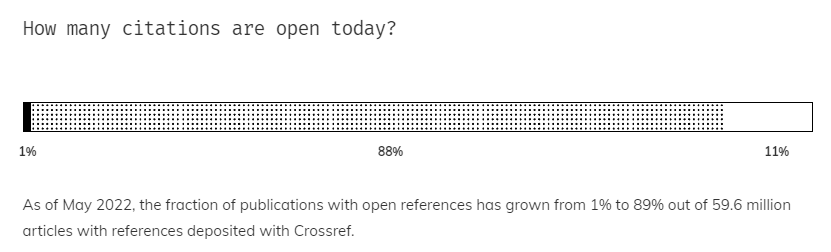

---
### Make plots

In [48]:
# make all numbers same color except for 0 references
color_dict = {num:'blue' for num in summary_df['num_cited_references'] if num != 0}
color_dict[0]='lightgray'

In [49]:
fig = px.histogram(summary_df, x='num_cited_references', nbins=50,
             color='num_cited_references',
             color_discrete_map=color_dict,
             title=f'Histogram of the Number of Cited References in {summary_df.shape[0]} Publications<br>Num_references=0 shown in light gray'
)
fig.update_layout(showlegend=False)

In [50]:
# Remove publications with 0 reported references
summary_df_no_zeros = summary_df.loc[summary_df['num_cited_references']!=0]
summary_df_no_zeros

,publication_title,publication_doi,num_cited_references
61,Reorienting Perspectives: Why I Do Not Teach a...,https://doi.org/10.1386/ijia_00033_1,1
62,"One Fish, Two Fish; Red Fish (or Green Fish?):...",https://doi.org/10.1177/0098628320959946,2
63,Iowa State University’s English placement test...,https://doi.org/10.1080/15434303.2020.1862122,2
64,Upholding Language Assessment Quality during t...,https://doi.org/10.1080/15434303.2020.1867555,3
65,"Soybean Gall Midge (Diptera: Cecidomyiidae), a...",https://doi.org/10.1093/jipm/pmab001,3
...,...,...,...
225,Differential Impact of Severity and Duration o...,https://doi.org/10.3389/fncel.2021.772868,157
226,Together We Rise: How Social Movements Succeed,https://doi.org/10.1002/jcpy.1201,183
227,NIH Workshop Report: sensory nutrition and dis...,https://doi.org/10.1093/ajcn/nqaa302,183
228,Supernova 2018cuf: A Type IIP Supernova with a...,https://doi.org/10.3847/1538-4357/abc417,190


In [51]:
summary_df_no_zeros.describe()

,num_cited_references
count,169.000000
mean,45.544379
std,39.021203
min,1.000000
25%,19.000000
50%,35.000000
75%,57.000000
max,200.000000


In [52]:
px.histogram(summary_df_no_zeros, x='num_cited_references', nbins=50,
             text_auto=True,
             title=f'Histogram of the Number of Cited References in {summary_df_no_zeros.shape[0]} Publications<br>Num_references=0 *removed*')

In [53]:
px.ecdf(summary_df, x='num_cited_references', ecdfnorm='percent',
       title=f'Cumulative Distribution of the Number of Cited References in {summary_df.shape[0]} Publications')

In [54]:
px.ecdf(summary_df_no_zeros, x='num_cited_references', ecdfnorm='percent',
       title=f'Cumulative Distribution of the Number of Cited References in {summary_df_no_zeros.shape[0]} Publications<br>Num_references=0 *removed*')

---

## 2.2 Look further at the years those references were published

In [57]:
df = pd.read_parquet('my_file_7697.parquet')
df.head(3)

,publication_title,publication_doi,publication_year,publication_journal,publication_publisher,referenced_title,referenced_doi,referenced_year,referenced_journal,reference_publisher,reference_citedby
0,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The handbook of crisis communication,https://doi.org/10.1002/9781444314885,2010,Published in <b>2010</b> in Chichester UK Mald...,Wiley-Blackwell,222
1,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The elaboration likelihood model of persuasion,https://doi.org/10.1016/s0065-2601(08)60214-2,1986,Advances in Experimental Social Psychology,Academic Press,5286
2,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The negative communication dynamic,https://doi.org/10.1108/13632540710843913,2007,Journal of Communication Management,Emerald (MCB UP),186


In [58]:
# Check distribution of number of references
df['publication_doi'].value_counts()

https://doi.org/10.1140/epjc/s10052-020-8227-9    200
https://doi.org/10.3847/1538-4357/abc417          190
https://doi.org/10.1093/ajcn/nqaa302              183
https://doi.org/10.1002/jcpy.1201                 183
https://doi.org/10.3389/fncel.2021.772868         157
                                                 ... 
https://doi.org/10.1111/1556-4029.14564             3
https://doi.org/10.1002/bes2.1812                   3
https://doi.org/10.1177/0098628320959946            2
https://doi.org/10.1080/15434303.2020.1862122       2
https://doi.org/10.1386/ijia_00033_1                1
Name: publication_doi, Length: 169, dtype: int64

### Oldest Reference is:

In [59]:
df.loc[df['referenced_year']==df['referenced_year'].min()]

,publication_title,publication_doi,publication_year,publication_journal,publication_publisher,referenced_title,referenced_doi,referenced_year,referenced_journal,reference_publisher,reference_citedby
4945,Sectional model of a prairie buffer strip in a...,https://doi.org/10.1002/agg2.20133,2021,"Agrosystems, geosciences & environment",Wiley,The Relation Between the Rainfall and the Disc...,https://doi.org/10.1061/taceat.0000694,1889,Transactions of the American Society of Civil ...,American Society of Civil Engineers,214


### Make plots

In [60]:
px.histogram(df, x='referenced_year', nbins=200, 
             title=f'Histogram of Cited Year<br>{summary_df.shape[0]} Publications and {df.shape[0]} References')

In [61]:
px.histogram(df, x='referenced_year', nbins=200, histnorm='probability density',
            title=f'Probability Density of the Cited Year<br>{summary_df.shape[0]} Publications and {df.shape[0]} References')

In [62]:
fig5 = px.ecdf(df, x='referenced_year', ecdfnorm='percent',markers=True, lines=False,
        color_discrete_map={'red':'red', 'blue':'blue'},
       title=f'Cumulative Distribution of Year of Citation<br>{df.shape[0]} references'
)
fig5.update_layout(showlegend=False)

## Track one DOI of interest

### Add 'color' column to control the colors and change color of one DOI to track it on the plot

In [66]:
# Change DOI in this line
red_doi = 'https://doi.org/10.1177/2329488417735646'

#https://doi.org/10.1007/s11425-018-1550-5   # publication with oldest average reference at 36 years
#https://doi.org/10.1386/ijia_00033_1  - 0 average year, referenced 1 work, which is itself?
#https://doi.org/10.1016/j.trgeo.2020.100410 - 10.25 average year
#https://doi.org/10.1177/2329488417735646 - 16 average year

df['color'] = 'blue'
red_title = df.loc[df['publication_doi']==red_doi, 'publication_title'].iloc[0]
red_title

'Crisis Management and Corporate Apology: The Effects of Causal Attribution and Apology Type on Publics’ Cognitive and Affective Responses:'

In [67]:
# Change color for that DOI to red
filt = (df['publication_doi'] == red_doi)
df.loc[filt,'color'] = 'red'

In [68]:
# Double check the number that you changed to red, should match number of references in that DOI
df['color'].value_counts()

blue    7656
red       41
Name: color, dtype: int64

In [69]:
fig2 = px.histogram(df, x='referenced_year', color='color', nbins=200,
             title=f'Years when Cited References were published<br>Red: "{red_title}"',
             hover_data={'color':False,
                         'referenced_title':True},
             color_discrete_map={'red':'red', 'blue':'blue'},
             category_orders={"color":['blue','red']}
)
fig2.update_layout(showlegend=False)

In [70]:
fig3 = px.box(df, x='referenced_year', points='all', color='color', notched=True,
       title=f'Years when Cited References were published<br>Red: "{red_title}"',
       hover_data={'color':False,
                    'referenced_title':True,
                   'publication_year':True,      
                   'publication':True},
       color_discrete_map={'red':'red', 'blue':'blue'},
       category_orders={"color":['blue','red']}
)
fig3.update_layout(showlegend=False)

ValueError: Value of 'hover_data_3' is not the name of a column in 'data_frame'. Expected one of ['publication_title', 'publication_doi', 'publication_year', 'publication_journal', 'publication_publisher', 'referenced_title', 'referenced_doi', 'referenced_year', 'referenced_journal', 'reference_publisher', 'reference_citedby', 'color'] but received: publication

In [ ]:
fig4 = px.ecdf(df, x='referenced_year', color='color', ecdfnorm='percent',markers=True, lines=False,
        color_discrete_map={'red':'red', 'blue':'blue'},
       title=f'Cumulative Distribution of Year of Citation in {df.shape[0]} Publications<br>Red: "{red_title}"'
)
fig4.update_layout(showlegend=False)

## Calculate the year delta, or how many years old a reference was when it got cited

In [71]:
df['year_delta'] = df['publication_year'] - df['referenced_year']

In [72]:
df.head(3)

,publication_title,publication_doi,publication_year,publication_journal,publication_publisher,referenced_title,referenced_doi,referenced_year,referenced_journal,reference_publisher,reference_citedby,color,year_delta
0,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The handbook of crisis communication,https://doi.org/10.1002/9781444314885,2010,Published in <b>2010</b> in Chichester UK Mald...,Wiley-Blackwell,222,red,11
1,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The elaboration likelihood model of persuasion,https://doi.org/10.1016/s0065-2601(08)60214-2,1986,Advances in Experimental Social Psychology,Academic Press,5286,red,35
2,Crisis Management and Corporate Apology: The E...,https://doi.org/10.1177/2329488417735646,2021,International journal of business communication,SAGE,The negative communication dynamic,https://doi.org/10.1108/13632540710843913,2007,Journal of Communication Management,Emerald (MCB UP),186,red,14


In [73]:
df['year_delta'].describe()

count    7697.000000
mean       11.203196
std        10.959907
min        -1.000000
25%         4.000000
50%         8.000000
75%        14.000000
max       132.000000
Name: year_delta, dtype: float64

### Group by publication, get one number per publication that shows the average age of its references

In [76]:
df2 = df.groupby('publication_title')['year_delta'].mean().to_frame(name='avg_year_delta')
df2.sample(5)  # 5 random results

,avg_year_delta
publication_title,
Determination of Diffusion Kinetics of Ketamine in Brain Tissue: Implications for in vitro Mechanistic Studies of Drug Actions,9.928571
"Organic agriculture effect on water use, tile flow, and crop yield",9.270270
Natural Horizontal Gene Transfer of Antimicrobial Resistance Genes in Campylobacter spp. From Turkeys and Swine,11.653333
Measurement of hadronic event shapes in high-pT multijet final states at $$ \sqrt{s} $$ = 13 TeV with the ATLAS detector,16.757576
Identification and Biology of Common Caterpillars in U.S. Soybean,30.111111


In [77]:
df2 = df2.sort_values(by='avg_year_delta')
df2

,avg_year_delta
publication_title,
Reorienting Perspectives: Why I Do Not Teach a Course Titled ‘Islamic Architecture’,0.000000
From the Editors: Introduction to Managing Supply Chains Beyond Covid‐19 ‐ Preparing for the Next Global Mega‐Disruption,0.142857
Mechanical and fracture properties of steel fiber-reinforced geopolymer concrete,2.120000
Iowa State University’s English placement test of oral communication in times of COVID-19,2.500000
Upholding Language Assessment Quality during the COVID-19 Pandemic: Some Final Thoughts and Questions,2.666667
...,...
"Glass transition temperature studies of planetary ball milled glasses: Accessing the rapidly cooled glassy state in Na4P2S7-xOx, 0 ≤ x ≤ 7, Oxy-thio phosphate glasses",24.742857
Impacts of agricultural price support policy on price variability and welfare: Evidence from China's soybean market,25.783784
"Soybean Gall Midge (Diptera: Cecidomyiidae), a New Species Causing Injury to Soybean in the United States",27.666667


In [78]:
df2['avg_year_delta'].describe()

count    169.000000
mean      11.779482
std        5.233166
min        0.000000
25%        8.342857
50%       11.102041
75%       14.363636
max       36.071429
Name: avg_year_delta, dtype: float64

In [79]:
px.ecdf(df2, x='avg_year_delta',
       title=f'Cumulative Distribution of the Average Age of Reference by Publication<br>{df2.shape[0]} Publications<br>'
)

---
# Part 3. Results

### Number of References
In this sample of 230 publications, 61 reported 0 references.

If we ignore those, the median number of references in the set of 169 publications was **35**, and the mean number was **45**. This shows how papers that have lots of references (4 with more than 180) pull up the mean.

### Individual References
Looking at all individual references, the median age is 8 years old (so, for 2021 publications, to a paper from 2013). The mean in this set is to a paper 11 years old, again showing the effect a very old paper can have in moving the mean (max age - 132 years, from 1889!).

By 2018, 20% of the references had been published. By 2004, 80% of references in this set had been published.

### Summarize by Publication

Grouping by publication shows an average age of all references for each publication. We see the mean (and median) of those average publication ages to be about 11 years.

80% of papers have an average year_delta of 15 years old or less. The remaining 20% of references are scattered across 20+ years

___
# Part 4. Conclusion

OpenAlex is an open scholarly metadata index / Knowledge Graph. This is in contrast to various other large scientometric data sets that are proprietary.

However, OpenAlex can only report the data it has, and it depends greatly on the sources of its data. Some publishers choose not to submit reference data to CrossRef, and it therefore does not show up in OpenAlex data. In the past, publishers could submit reference data to CrossRef but opt to keep it closed; this changed in June 2022 so now *any* reference data submitted to CrossRef will now be made open.

These shortcomings limit the data and the findings here. Any conclusions should be taken as a minimum, as there are undoubtedly missing references and publication data.

#### Future Work
I thought that restricting the scope to look at only one year of publications from one university would limit the data enough to not overwhelm me. However, I found that even pulling 1 day of publications (Jan 1, 2021) gave me 230 results and 7,600 cited references, taking 35 minutes to run in OpenAlex.

Scaling this up to pull a full year of 3,500 publications and their projected 115,600 references would take an estimated 7.5 hours of active API time.

Building further to pull multiple years and look across time would take another ~8 hours of API time per year of publications. 

This is more involved than I had thought. It remains possible, but will require more careful consideration of how and when to run the data pulls in chunks. However, once I have the data saved, the plots seen above will still work.